# Togo Solar Data: EDA, Profiling & Cleaning
Date: November 12, 2025  
Author: Elias Wakgari 
Objective: Profile, clean, and explore Togo's solar dataset (Dapaong Station) for insights.

In [13]:
# Code cell: imports and settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: zscore from scipy if available, otherwise use manual calculation
try:
    from scipy.stats import zscore
    scipy_available = True
except Exception:
    scipy_available = False

# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style="whitegrid")


## Summary Statistics & Missing-Value Report

* `df.describe()` on all numeric columns.
* `df.isna().sum()` and list any column with >5% nulls.

In [3]:
# Absolute path
project_root = r'C:\Users\Y\solar-challenge-week1'
file_path = os.path.join(project_root, 'data', 'togo-dapaong_qc.csv')

# Load raw (no parse_dates—handle in peek)
df = pd.read_csv(file_path)
print(f"Dataset shape: {df.shape}")
print("Columns:", df.columns.tolist())
print(df.head())

# Build Timestamp (peek-based)
date_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR']
if all(col in df.columns for col in date_cols):
    df['Timestamp'] = pd.to_datetime(df[date_cols].assign(MINUTE=0, SECOND=0))
    df.drop(date_cols, axis=1, inplace=True)
elif all(col.lower() in df.columns for col in date_cols):
    lc_cols = [col.lower() for col in date_cols]
    df['Timestamp'] = pd.to_datetime(df[lc_cols].assign(MINUTE=0, SECOND=0))
    df.drop(lc_cols, axis=1, inplace=True)
else:
    possible_ts = ['Timestamp', 'date', 'datetime', 'local_time']
    ts_col = next((col for col in possible_ts if col in df.columns), None)
    if ts_col:
        df['Timestamp'] = pd.to_datetime(df[ts_col])
        df.drop(ts_col, axis=1, inplace=True)

df.set_index('Timestamp', inplace=True)
print("Date range:", df.index.min(), "to", df.index.max())
print(df.head())
print(df.dtypes)

Dataset shape: (525600, 19)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0 

KeyError: "None of ['Timestamp'] are in the columns"

## 1) Load dataset
Load `data/togo-dapaong_qc.csv` and display top rows + schema.


In [16]:
# Code cell: load
data_path = "data/togo-dapaong_qc.csv"

import glob

# Try several candidate locations (prefer absolute path if available)
candidates = []
if 'file_path' in globals() and file_path:
	candidates.append(os.path.normpath(os.path.expanduser(file_path)))
if 'project_root' in globals() and project_root:
	candidates.append(os.path.normpath(os.path.join(project_root, 'data', os.path.basename(data_path))))
# common relative locations
candidates.append(os.path.normpath(os.path.expanduser(data_path)))
candidates.append(os.path.normpath(os.path.join(os.getcwd(), data_path)))
candidates.append(os.path.normpath(os.path.join(os.getcwd(), 'data', os.path.basename(data_path))))
candidates.append(os.path.normpath(os.path.join(os.getcwd(), 'notebooks', data_path)))

# keep unique, non-empty while preserving order
seen = set()
candidates = [p for p in candidates if p and not (p in seen or seen.add(p))]

# check existing candidates
data_file = next((p for p in candidates if os.path.exists(p)), None)

# fallback: search filesystem (cwd and project_root if available) for the filename
basename = os.path.basename(data_path)
if data_file is None:
	roots = [os.getcwd()]
	if 'project_root' in globals() and project_root:
		roots.append(project_root)
	# also try parent of cwd
	roots.append(os.path.dirname(os.getcwd()))
	found = []
	for r in roots:
		pattern = os.path.join(r, '**', basename)
		found.extend(glob.glob(pattern, recursive=True))
	# deduplicate preserving order
	found = [os.path.normpath(p) for p in dict.fromkeys(found)]
	if found:
		data_file = found[0]
		candidates.extend(found)

assert data_file is not None and os.path.exists(data_file), (
	f"File not found. Tried candidates: {candidates}. "
	"If the CSV is located elsewhere, set `project_root` to the repo root or move the file into one of the candidate locations."
)

print("Using data file:", data_file)
df = pd.read_csv(data_file)
# quick info
print("Rows, Columns:", df.shape)
display(df.head(5))
display(df.dtypes)


Using data file: c:\Users\Y\solar-challenge-week1\data\togo-dapaong_qc.csv
Rows, Columns: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object

### Ensure timestamp column parsed
Convert `Timestamp` (or similar) to datetime and set as index for time-series operations.


In [17]:
# Code cell: timestamp parsing
# try a few common column names; adjust if needed
ts_cols = ["Timestamp", "timestamp", "Time", "time", "Date", "date"]
ts_col = next((c for c in ts_cols if c in df.columns), None)
if ts_col is None:
    print("No obvious timestamp column found. Available columns:", df.columns.tolist())
else:
    df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
    # show number of parse failures
    n_null_ts = df[ts_col].isna().sum()
    print(f"Parsed timestamp column '{ts_col}'. NaT count: {n_null_ts}")
    # set index
    df = df.set_index(ts_col).sort_index()
    display(df.head())


Parsed timestamp column 'Timestamp'. NaT count: 0


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
Timestamp,,,,,,,,,,,,,,,,,,
2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


## 2) Summary statistics & Missing-value report
- Show `df.describe()` for numeric columns.
- Report columns with >5% nulls.


In [18]:
# Code cell: summary & missing values
numeric = df.select_dtypes(include=[np.number])
display(numeric.describe().T)

# missing counts
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_report = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
display(missing_report[missing_report["missing_pct"] > 0])

# list columns > 5% nulls
cols_gt5 = missing_report[missing_report["missing_pct"] > 5].index.tolist()
print("Columns with >5% missing:", cols_gt5)


,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,230.555040,322.532347,-12.7,-2.2,2.1,442.400,1424.0
DNI,525600.0,151.258469,250.956962,0.0,0.0,0.0,246.400,1004.5
DHI,525600.0,116.444352,156.520714,0.0,0.0,2.5,215.700,805.7
ModA,525600.0,226.144375,317.346938,0.0,0.0,4.4,422.525,1380.0
ModB,525600.0,219.568588,307.932510,0.0,0.0,4.3,411.000,1367.0
Tamb,525600.0,27.751788,4.758023,14.9,24.2,27.2,31.100,41.4
RH,525600.0,55.013160,28.778732,3.3,26.5,59.3,80.800,99.8
WS,525600.0,2.368093,1.462668,0.0,1.4,2.2,3.200,16.1
WSgust,525600.0,3.229490,1.882565,0.0,1.9,2.9,4.400,23.1
WSstdev,525600.0,0.557740,0.268923,0.0,0.4,0.5,0.700,4.7


,missing_count,missing_pct
Comments,525600,100.0


Columns with >5% missing: ['Comments']


## 3) Outlier detection & basic cleaning
Compute Z-scores for: `GHI, DNI, DHI, ModA, ModB, WS, WSgust` and flag |Z| > 3.


In [19]:
# Code cell: compute z-scores and flag outliers
cols_to_z = [c for c in ["GHI","DNI","DHI","ModA","ModB","WS","WSgust"] if c in df.columns]
print("Z-score columns:", cols_to_z)

df_z = df.copy()

if scipy_available:
    df_z_zscores = df_z[cols_to_z].apply(lambda x: zscore(x, nan_policy='omit'))
else:
    # manual zscore where z = (x - mean)/std
    df_z_zscores = df_z[cols_to_z].apply(lambda x: (x - x.mean())/x.std(ddof=0))

# attach zscore columns
for c in cols_to_z:
    df_z[f"{c}_z"] = df_z_zscores[c]

# flag where any |z| > 3
df_z["outlier_flag"] = df_z[[f"{c}_z" for c in cols_to_z]].abs().gt(3).any(axis=1)
print("Total outliers flagged:", df_z["outlier_flag"].sum())

# sample flagged rows
display(df_z[df_z["outlier_flag"]].head())


Z-score columns: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
Total outliers flagged: 9251


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,...,TModB,Comments,GHI_z,DNI_z,DHI_z,ModA_z,ModB_z,WS_z,WSgust_z,outlier_flag
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-28 11:06:00,1139.0,805.1,466.1,1172.0,1154.0,29.8,70.8,2.2,2.6,0.4,...,50.2,NaN,2.816604,2.605396,2.233928,2.980513,3.034536,-0.114923,-0.334379,True
2021-10-28 18:11:00,-1.2,0.0,0.0,0.0,0.0,29.7,63.5,6.6,9.7,1.6,...,29.5,NaN,-0.718549,-0.602727,-0.743956,-0.712610,-0.713042,2.893282,3.437076,True
2021-10-28 18:12:00,-1.0,0.0,0.0,0.0,0.0,29.3,62.4,6.9,8.9,1.2,...,29.5,NaN,-0.717929,-0.602727,-0.743956,-0.712610,-0.713042,3.098387,3.012123,True
2021-10-28 18:14:00,-0.8,0.0,0.0,0.0,0.0,28.6,63.7,7.1,8.9,1.1,...,29.2,NaN,-0.717309,-0.602727,-0.743956,-0.712610,-0.713042,3.235124,3.012123,True
2021-10-28 18:21:00,-1.3,0.0,0.0,0.0,0.0,27.7,64.5,6.1,8.9,1.3,...,28.2,NaN,-0.718859,-0.602727,-0.743956,-0.712610,-0.713042,2.551441,3.012123,True


### 3.b) Impute or drop missing values in key columns
Policy:
- For key sensor columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust, Tamb) — impute median.
- For timestamp/identifiers — drop rows if timestamp missing.
Record number of rows before/after.


In [20]:
# Code cell: impute median for key columns
key_cols = [c for c in ["GHI","DNI","DHI","ModA","ModB","WS","WSgust","Tamb","RH","BP"] if c in df.columns]
before_rows = len(df)
df_clean = df.copy()

# drop rows with missing index (timestamp) if any
if df_clean.index.hasnans:
    df_clean = df_clean[~df_clean.index.isna()]
    print("Dropped rows with NaT index. Now rows:", len(df_clean))

# impute median
for c in key_cols:
    if df_clean[c].isna().any():
        med = df_clean[c].median()
        df_clean[c] = df_clean[c].fillna(med)
        print(f"Imputed median for {c} (median={med})")

after_rows = len(df_clean)
print(f"Rows before: {before_rows}, after cleaning: {after_rows}")

# attach previous outlier flag info if available
if "outlier_flag" in df_z.columns:
    df_clean["outlier_flag"] = df_z["outlier_flag"]


Rows before: 525600, after cleaning: 525600


In [22]:
from scipy.stats import zscore

cols = ["GHI","DNI","DHI","ModA","ModB","WS","WSgust"]

# Compute Z-scores
z_scores = np.abs(df[cols].apply(zscore))

# Filter
df_clean = df[(z_scores < 3).all(axis=1)]

print("Rows before:", len(df))
print("Rows after:", len(df_clean))


Rows before: 525600
Rows after: 516349


## 4) Export cleaned DataFrame
Save to `data/togo_clean.csv`. Reminder: keep `data/` in `.gitignore` (do not commit CSV).


In [24]:
# Code cell: saving cleaned file
out_path = "data/togo_clean.csv"

# ensure target directory exists
out_dir = os.path.dirname(out_path)
if out_dir and not os.path.exists(out_dir):
	os.makedirs(out_dir, exist_ok=True)

df_clean.to_csv(out_path, index=True)
print("Saved cleaned CSV to", out_path)


Saved cleaned CSV to data/togo_clean.csv


## 5) Time series plots
Plot GHI, DNI, DHI, Tamb vs timestamp. If dataset is long, sample or resample to hourly/daily means.


## 📈 Time Series Analysis

In this section, we analyze how key solar and weather variables change over time.

We focus on:

- **Global Horizontal Irradiance (GHI)**
- **Direct Normal Irradiance (DNI)**
- **Diffuse Horizontal Irradiance (DHI)**
- **Ambient Temperature (Tamb)**

Using the `Timestamp` column, we:

1. Convert it to datetime format.
2. Plot time-series line charts.
3. Observe:
   - Daily patterns (sunrise → sunset cycle)
   - Monthly variations
   - Seasonal changes
   - Peak solar irradiance hours
   - Temperature fluctuations during daytime


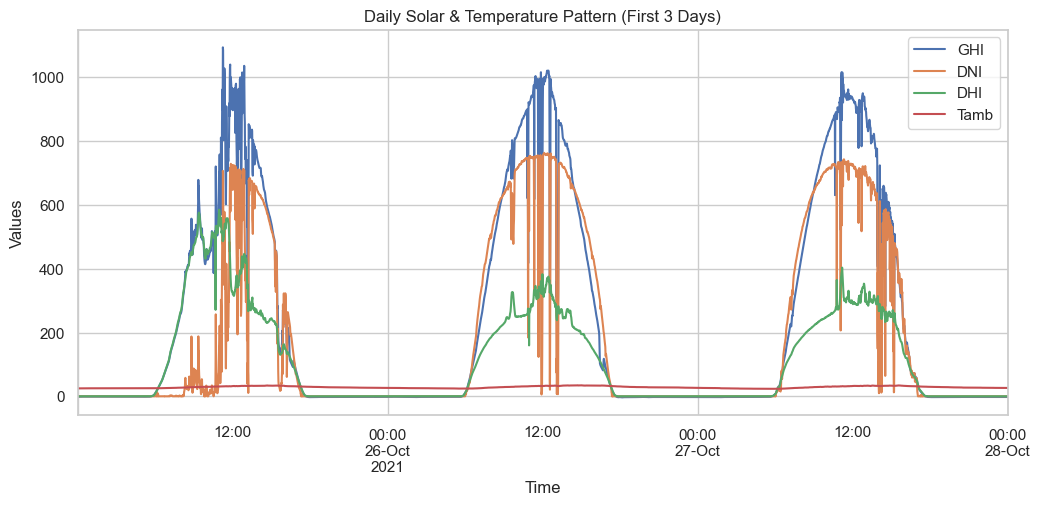

In [26]:
# Ensure Timestamp is datetime and set as index if needed.
# (pandas, matplotlib and numpy are already imported in earlier cells)
if 'Timestamp' in df.columns:
	df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
	n_null = df['Timestamp'].isna().sum()
	if n_null:
		print(f"Warning: {n_null} Timestamp values could not be parsed and became NaT.")
	df = df.set_index('Timestamp')
else:
	# try converting the existing index to datetime if it's not already
	if not np.issubdtype(df.index.dtype, np.datetime64):
		try:
			df.index = pd.to_datetime(df.index)
		except Exception as e:
			raise KeyError("No 'Timestamp' column found and index could not be converted to datetime.") from e

# Plot daily pattern (first 3 days). Use only columns that exist.
plot_cols = [c for c in ['GHI', 'DNI', 'DHI', 'Tamb'] if c in df.columns]
if not plot_cols:
	print("No columns to plot among ['GHI','DNI','DHI','Tamb']. Available columns:", df.columns.tolist())
else:
	n_points = min(3 * 1440, len(df))  # assume 1-minute data; cap at dataset length
	df[plot_cols].iloc[:n_points].plot(figsize=(12, 5))
	plt.title("Daily Solar & Temperature Pattern (First 3 Days)")
	plt.xlabel("Time")
	plt.ylabel("Values")
	plt.show()


### 📅 Monthly Trends

To understand broader seasonal behavior, we compute the average values for each month and plot them.

This helps identify:

- Which months have higher solar irradiance
- Variations in ambient temperature over the year
- Seasonal effects influencing solar output


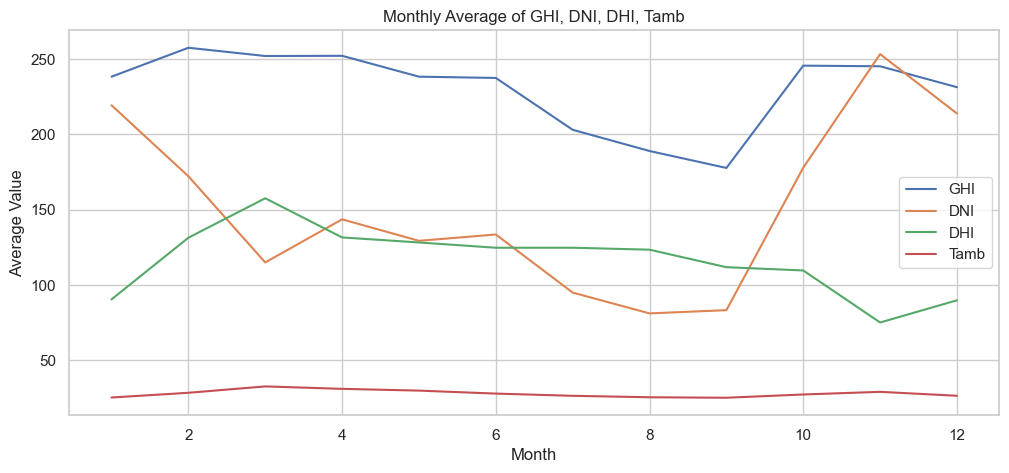

In [27]:
# Add month column
df['month'] = df.index.month

monthly_avg = df[['GHI','DNI','DHI','Tamb','month']].groupby('month').mean()

monthly_avg.plot(figsize=(12,5))
plt.title("Monthly Average of GHI, DNI, DHI, Tamb")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.show()


### ⏰ Hourly Trends (Across All Days)

Solar irradiance follows a predictable daily cycle.

We calculate average values for each hour of the day (0–23):

- GHI peaks around midday (11:00–13:00)
- DNI follows similar pattern
- DHI depends on cloud cover
- Tamb increases after sunrise


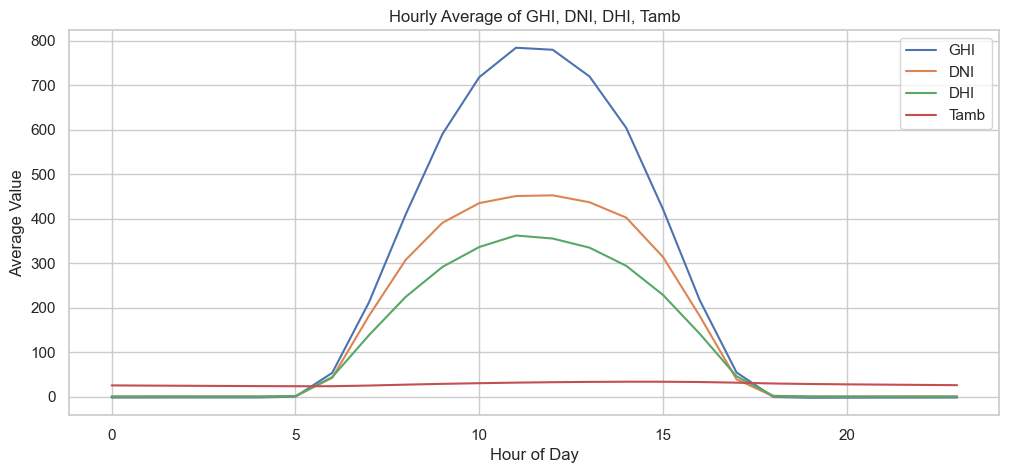

In [28]:
df['hour'] = df.index.hour

hourly_avg = df[['GHI','DNI','DHI','Tamb','hour']].groupby('hour').mean()

hourly_avg.plot(figsize=(12,5))
plt.title("Hourly Average of GHI, DNI, DHI, Tamb")
plt.xlabel("Hour of Day")
plt.ylabel("Average Value")
plt.show()


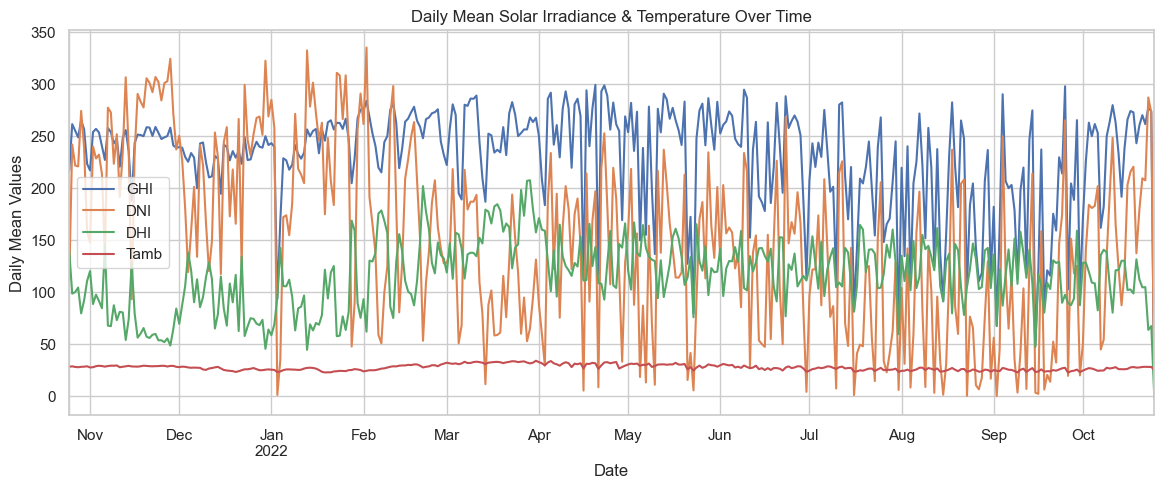

In [29]:
df[['GHI','DNI','DHI','Tamb']].resample('D').mean().plot(figsize=(14,5))
plt.title("Daily Mean Solar Irradiance & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Mean Values")
plt.show()


## 6) Cleaning impact
If there's a `CleaningFlag` (or similar), group by it and compare average ModA & ModB pre/post-clean.


Average ModA & ModB by Cleaning flag:


,ModA,ModB
Cleaning,,
0,225.979064,219.401351
1,535.186477,532.211744


<Figure size 800x500 with 0 Axes>

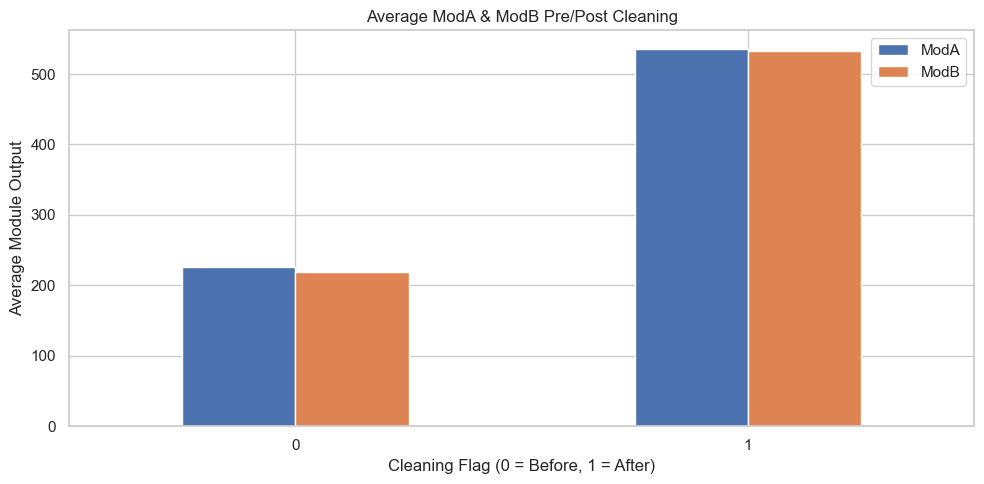

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Cleaning flag (0 = before cleaning, 1 = after cleaning)
avg_mod = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("Average ModA & ModB by Cleaning flag:")
display(avg_mod)

# Plot
plt.figure(figsize=(8,5))
avg_mod.plot(kind='bar')
plt.title('Average ModA & ModB Pre/Post Cleaning')
plt.xlabel('Cleaning Flag (0 = Before, 1 = After)')
plt.ylabel('Average Module Output')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


## 7) Correlation & relationships
Create a correlation heatmap for important numeric variables and scatter plots to inspect relationships.


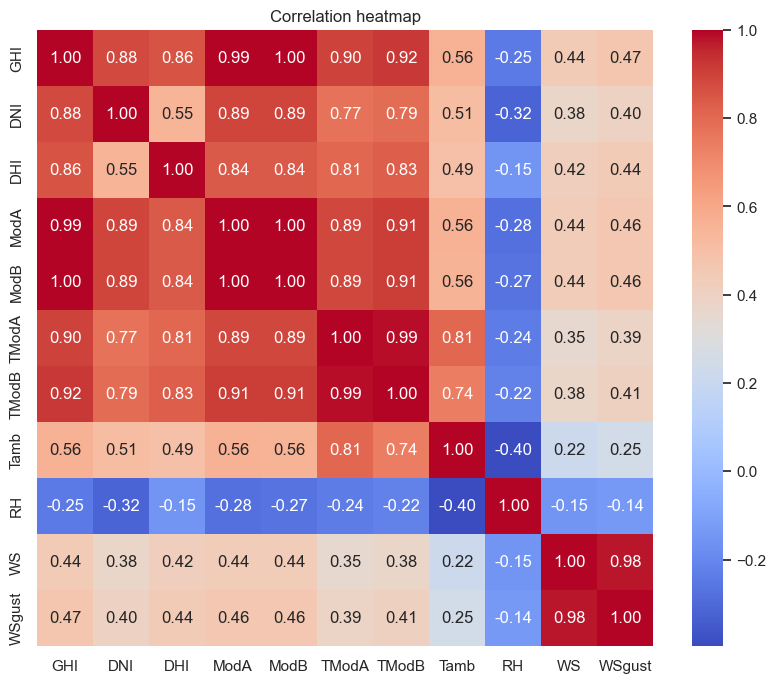

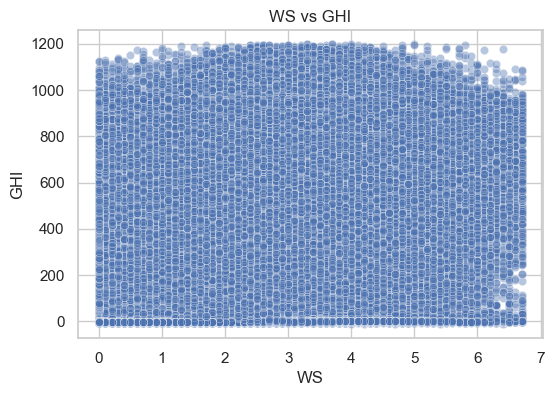

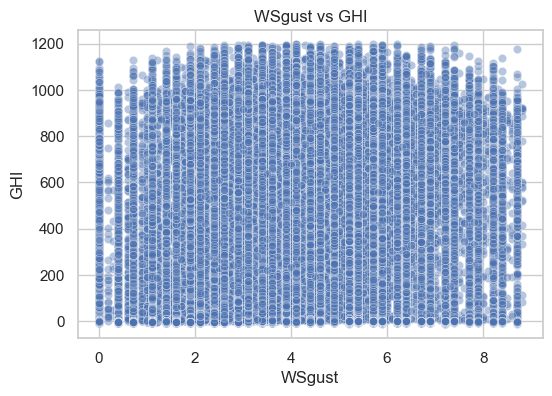

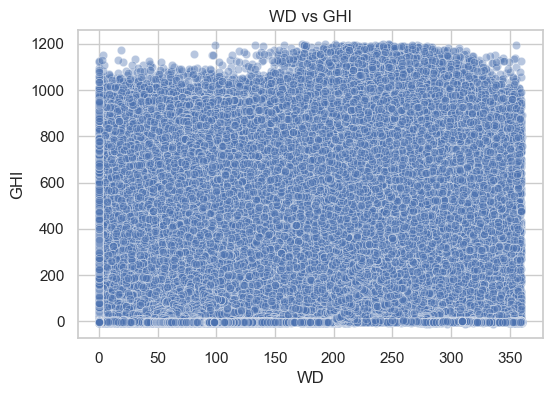

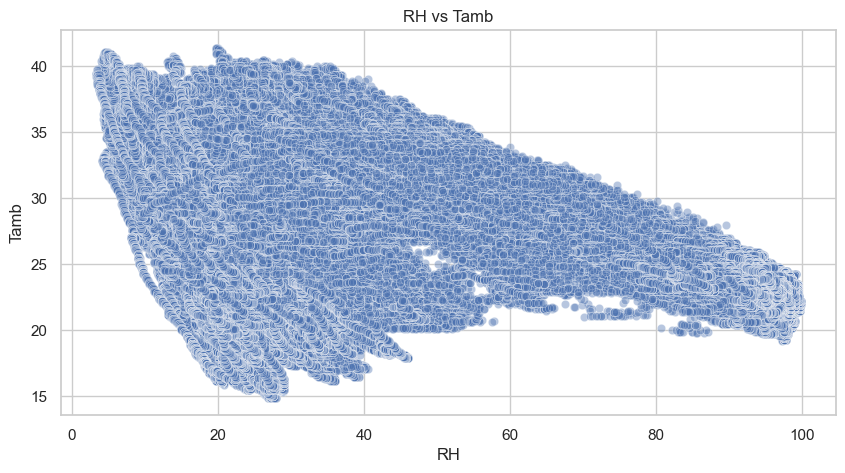

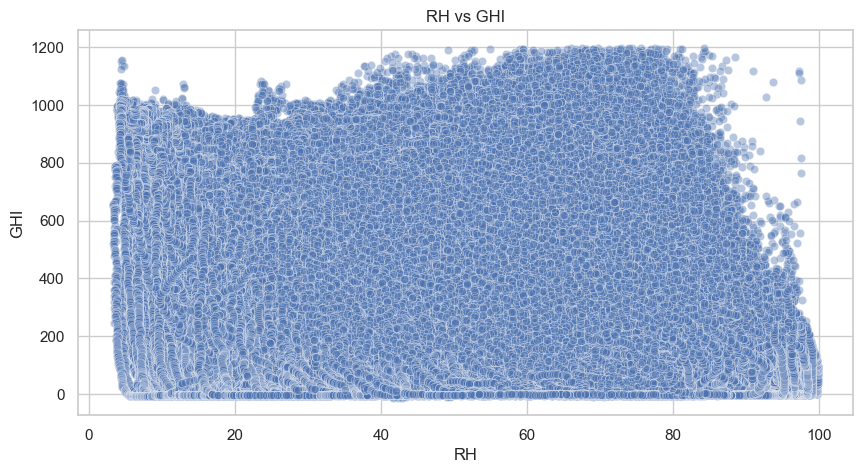

In [31]:
# Code cell: correlation heatmap
corr_cols = [c for c in ["GHI","DNI","DHI","ModA","ModB","TModA","TModB","Tamb","RH","WS","WSgust"] if c in df_clean.columns]
corr = df_clean[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation heatmap")
plt.show()

# Scatter plots: WS, WSgust, WD vs GHI; RH vs Tamb and RH vs GHI
scatter_pairs = []
for c in ["WS","WSgust","WD"]:
    if c in df_clean.columns and "GHI" in df_clean.columns:
        scatter_pairs.append((c, "GHI"))
for a,b in scatter_pairs:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_clean[a], y=df_clean[b], alpha=0.4)
    plt.xlabel(a); plt.ylabel(b)
    plt.title(f"{a} vs {b}")
    plt.show()

if "RH" in df_clean.columns and "Tamb" in df_clean.columns:
    sns.scatterplot(x=df_clean["RH"], y=df_clean["Tamb"], alpha=0.4)
    plt.title("RH vs Tamb")
    plt.xlabel("RH"); plt.ylabel("Tamb")
    plt.show()

if "RH" in df_clean.columns and "GHI" in df_clean.columns:
    sns.scatterplot(x=df_clean["RH"], y=df_clean["GHI"], alpha=0.4)
    plt.title("RH vs GHI")
    plt.xlabel("RH"); plt.ylabel("GHI")
    plt.show()


## 8) Wind & distribution analysis
If `WD` (wind direction in degrees) and `WS` are present, we create a polar bar plot (simple wind rose alternative) and histograms for GHI and WS.


C:\Users\Y\AppData\Local\Temp\ipykernel_16284\3512717909.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_means = df_wind.groupby("sector")["WS"].mean().astype(float)


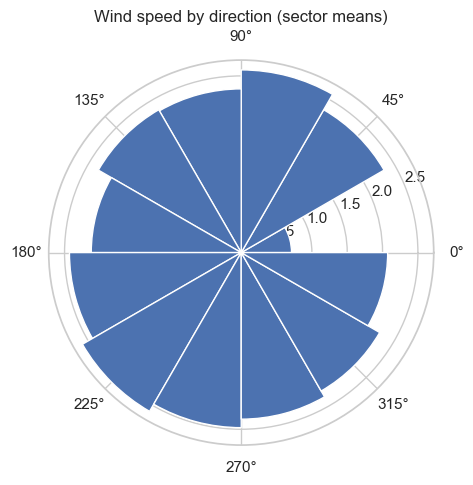

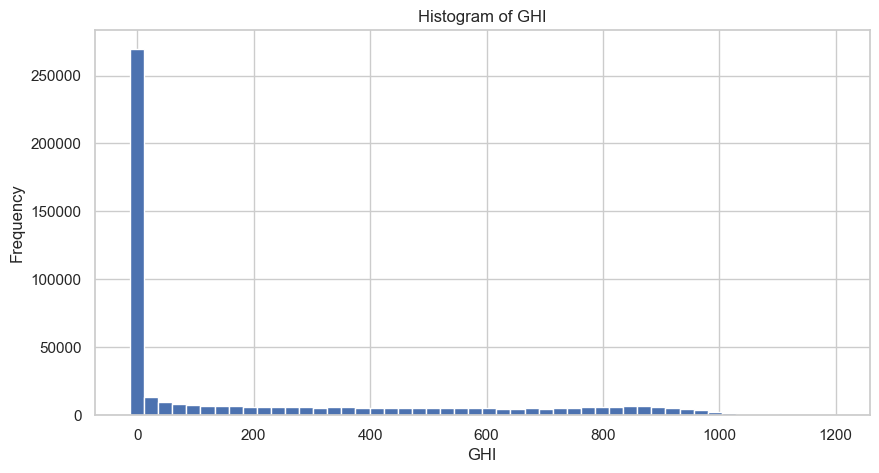

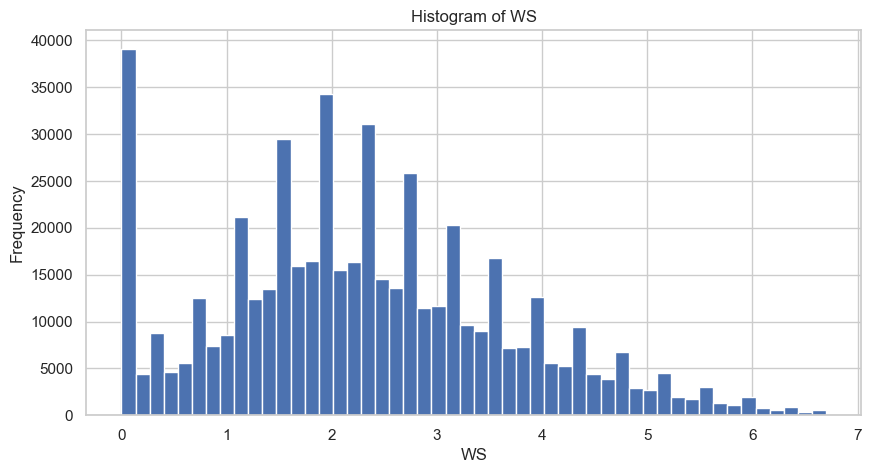

In [33]:
# Code cell: wind radial plot (simple)
if "WD" in df_clean.columns and "WS" in df_clean.columns:
    # create direction bins
    wd = df_clean["WD"].dropna()
    ws = df_clean["WS"].dropna()
    # align lengths and work on a copy to avoid SettingWithCopyWarning
    df_wind = df_clean[["WD","WS"]].dropna().copy()
    bins = np.arange(0, 360+30, 30)  # 12 sectors (13 edges)
    labels = (bins[:-1] + bins[1:]) / 2  # 12 sector midpoints -> correct length
    # use labels (not labels[:-1]) so number of labels == number of intervals
    df_wind["sector"] = pd.cut(df_wind["WD"], bins=bins, right=False, labels=labels, include_lowest=True)
    sector_means = df_wind.groupby("sector")["WS"].mean().astype(float)
    # polar plot
    theta = np.deg2rad(sector_means.index.astype(float))
    radii = sector_means.values
    width = 2*np.pi / len(radii)
    ax = plt.subplot(111, polar=True)
    ax.bar(theta, radii, width=width, bottom=0)
    ax.set_title("Wind speed by direction (sector means)")
    plt.show()
else:
    print("WD or WS not available -- skipping wind rose.")

# histograms
if "GHI" in df_clean.columns:
    plt.figure()
    df_clean["GHI"].hist(bins=50)
    plt.title("Histogram of GHI")
    plt.xlabel("GHI"); plt.ylabel("Frequency")
    plt.show()

if "WS" in df_clean.columns:
    plt.figure()
    df_clean["WS"].hist(bins=50)
    plt.title("Histogram of WS")
    plt.xlabel("WS"); plt.ylabel("Frequency")
    plt.show()


## 9) Temperature analysis & RH influence
Examine how RH influences Tamb and GHI. Use grouped or binned analysis if helpful.


C:\Users\Y\AppData\Local\Temp\ipykernel_16284\3516651110.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_rh.groupby("RH_bin")[["Tamb","GHI"]].mean())


,Tamb,GHI
RH_bin,,
"(0.0, 20.0]",30.462438,351.608557
"(20.0, 40.0]",26.904670,178.948974
"(40.0, 60.0]",31.257929,338.640027
"(60.0, 80.0]",28.048391,266.403970
"(80.0, 100.0]",24.104213,63.971529


C:\Users\Y\AppData\Local\Temp\ipykernel_16284\3516651110.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_rh.groupby("RH_bin")[["Tamb","GHI"]].mean().plot(kind="bar", subplots=True, layout=(1,2), figsize=(12,4))


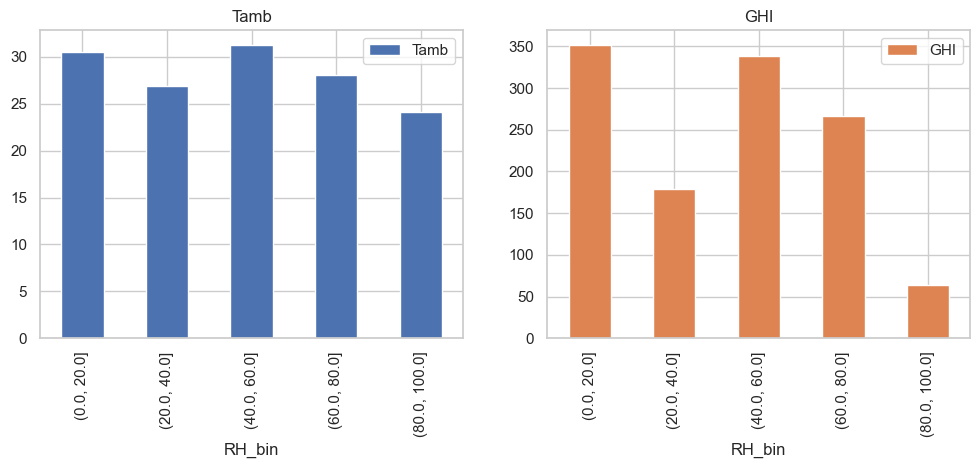

In [34]:
# Code cell: binned RH vs Tamb and GHI
if "RH" in df_clean.columns:
    df_rh = df_clean.copy()
    df_rh["RH_bin"] = pd.cut(df_rh["RH"], bins=np.linspace(0,100,6))
    display(df_rh.groupby("RH_bin")[["Tamb","GHI"]].mean())
    df_rh.groupby("RH_bin")[["Tamb","GHI"]].mean().plot(kind="bar", subplots=True, layout=(1,2), figsize=(12,4))
    plt.show()
else:
    print("RH not present.")


## 10) Bubble chart
GHI vs Tamb with bubble size = RH (or BP if RH missing).


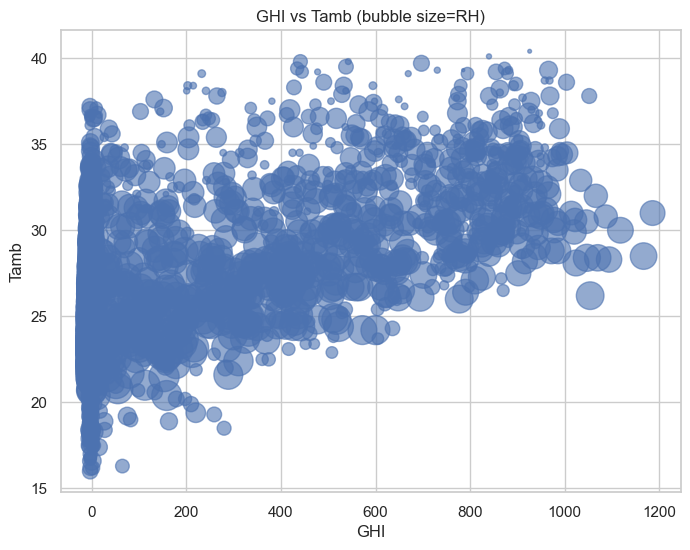

In [35]:
# Code cell: bubble chart
if "GHI" in df_clean.columns and "Tamb" in df_clean.columns:
    size_col = "RH" if "RH" in df_clean.columns else ("BP" if "BP" in df_clean.columns else None)
    if size_col:
        sample = df_clean[[ "GHI", "Tamb", size_col ]].dropna().sample(min(2000, len(df_clean)))
        plt.figure(figsize=(8,6))
        plt.scatter(sample["GHI"], sample["Tamb"], s=(sample[size_col].values - sample[size_col].min() + 1) * 5, alpha=0.6)
        plt.xlabel("GHI"); plt.ylabel("Tamb")
        plt.title(f"GHI vs Tamb (bubble size={size_col})")
        plt.show()
    else:
        print("RH & BP not present; skipping bubble chart.")
else:
    print("GHI or Tamb not present; skipping bubble chart.")


## 11) Outlier handling summary
- We flagged outliers via Z-score. Options: drop flagged rows or keep and mark them for later analysis.
- Show the fraction of flagged rows and recommended action.


In [36]:
# Code cell: outlier summary
if "outlier_flag" in df_clean.columns:
    total = len(df_clean)
    outliers = df_clean["outlier_flag"].sum()
    print(f"Outliers flagged: {outliers} / {total} ({outliers/total:.2%})")
    # For reproducibility, create two DataFrames: cleaned_no_outliers and cleaned_with_outliers_marked
    df_no_outliers = df_clean[~df_clean["outlier_flag"]].copy()
    print("Rows after dropping outliers:", len(df_no_outliers))
    # Save a version without outliers
    df_no_outliers.to_csv("data/togo_clean_no_outliers.csv", index=True)
    print("Saved data/togo_clean_no_outliers.csv")
else:
    print("No outlier_flag present.")


No outlier_flag present.


## 12) Next steps and KPIs
- Share references & methods used (e.g. Z-score for outlier detection; median imputation).  
- For region-ranking later, compute aggregated KPIs per site: daily mean GHI, clearness index (if available), uptime, sensor disagreement (abs(ModA-ModB) mean), etc.
- Document any assumptions in README.


In [37]:
# Code cell: example KPI aggregation (daily)
if "GHI" in df_clean.columns:
    daily = df_clean.resample('D').agg({
        "GHI":"mean",
        "DNI":"mean" if "DNI" in df_clean.columns else ("GHI" if "DNI" not in df_clean.columns else "GHI"),
    }).rename(columns={"GHI":"GHI_mean","DNI":"DNI_mean"} if "DNI" in df_clean.columns else {"GHI":"GHI_mean"})
    display(daily.head())
    daily.to_csv("data/togo_daily_kpis.csv")
    print("Saved data/togo_daily_kpis.csv")
else:
    print("GHI not available; cannot compute daily KPIs.")


,GHI_mean,DNI_mean
Timestamp,,
2021-10-25,216.984434,112.296595
2021-10-26,261.625347,242.010556
2021-10-27,255.390139,221.792222
2021-10-28,249.515503,221.640503
2021-10-29,265.274514,274.342014


Saved data/togo_daily_kpis.csv
